In [2]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

# SIR Model with new Data Set

Goal of the exercise: A dynamic dashboard of the last cell in the notebook, where one can select the fit for different countries

In [4]:
df_analyse=pd.read_csv("../data/raw/covid_full_data.csv",sep=';')  
df_analyse.tail()

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
196769,196769,ZWE,Africa,Zimbabwe,2022-06-21,254919.0,88.0,109.143,5536.0,2.0,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
196770,196770,ZWE,Africa,Zimbabwe,2022-06-22,255049.0,130.0,94.571,5541.0,5.0,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
196771,196771,ZWE,Africa,Zimbabwe,2022-06-23,255136.0,87.0,90.571,5542.0,1.0,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
196772,196772,ZWE,Africa,Zimbabwe,2022-06-24,255309.0,173.0,79.429,5549.0,7.0,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
196773,196773,ZWE,Africa,Zimbabwe,2022-06-25,255309.0,NaN,NaN,5549.0,0.0,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [51]:
df_analyse.columns

Index(['Unnamed: 0', 'iso_code', 'continent', 'location', 'date',
       'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths',
       'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smooth

In [15]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
total_cases_germany = df_analyse.total_cases[df_analyse.location=='Germany']
I0=total_cases_germany.iloc[35]
S0=N0-I0
R0=0

In [18]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

# Simulative approach to calculate SIR curves

In [20]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

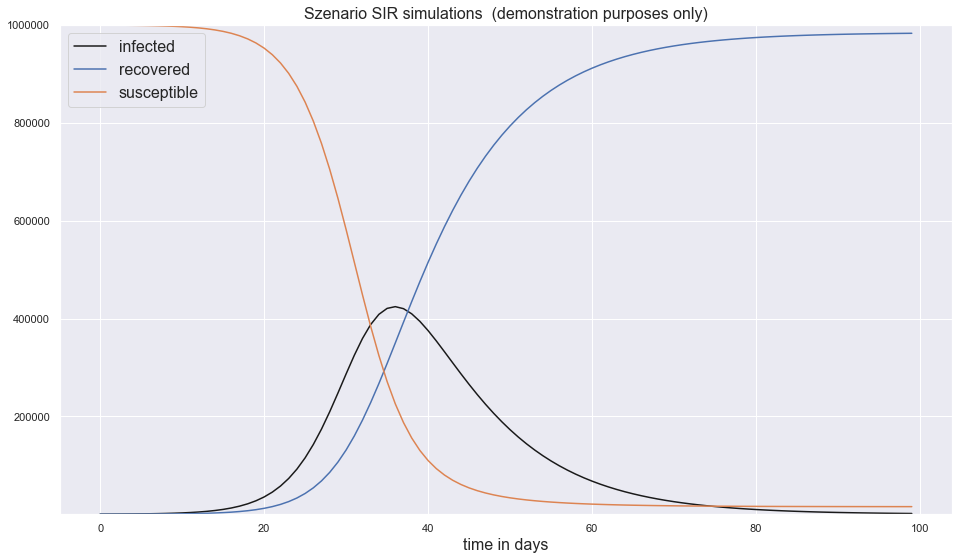

In [21]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters of SIR model (for Germany)

In [22]:
ydata = np.array(total_cases_germany.iloc[35:])
t=np.arange(len(ydata))

In [23]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [24]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [25]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [26]:
# example curve of our differential equationa
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([ 1.50000000e+02,  2.02463982e+02,  2.73268842e+02,  3.68819041e+02,
        4.97749399e+02,  6.71696875e+02,  9.06335369e+02,  1.22275981e+03,
        1.64933137e+03,  2.22412645e+03,  2.99816685e+03,  4.03964398e+03,
        5.43937699e+03,  7.31774561e+03,  9.83327943e+03,  1.31929070e+04,
        1.76634716e+04,  2.35833585e+04,  3.13717574e+04,  4.15310170e+04,
        5.46347118e+04,  7.12909430e+04,  9.20686199e+04,  1.17377266e+05,
        1.47302815e+05,  1.81425938e+05,  2.18681062e+05,  2.57335198e+05,
        2.95149063e+05,  3.29716023e+05,  3.58885018e+05,  3.81122439e+05,
        3.95696349e+05,  4.02654106e+05,  4.02648797e+05,  3.96705067e+05,
        3.86000511e+05,  3.71702658e+05,  3.54869154e+05,  3.36400476e+05,
        3.17028686e+05,  2.97327259e+05,  2.77731012e+05,  2.58559183e+05,
        2.40037812e+05,  2.22319621e+05,  2.05500760e+05,  1.89634472e+05,
        1.74741972e+05,  1.60820989e+05,  1.47852381e+05,  1.35805217e+05,
        1.24640639e+05,  

In [27]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

In [28]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

C:\Users\Johannes\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Johannes\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
C:\Users\Johannes\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Johannes\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [4.53940513e-04 6.73057363e-05]  start infect: 150.0
Optimal parameters: beta = 0.019822769151808105  and gamma =  -0.006621589918702324


In [29]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

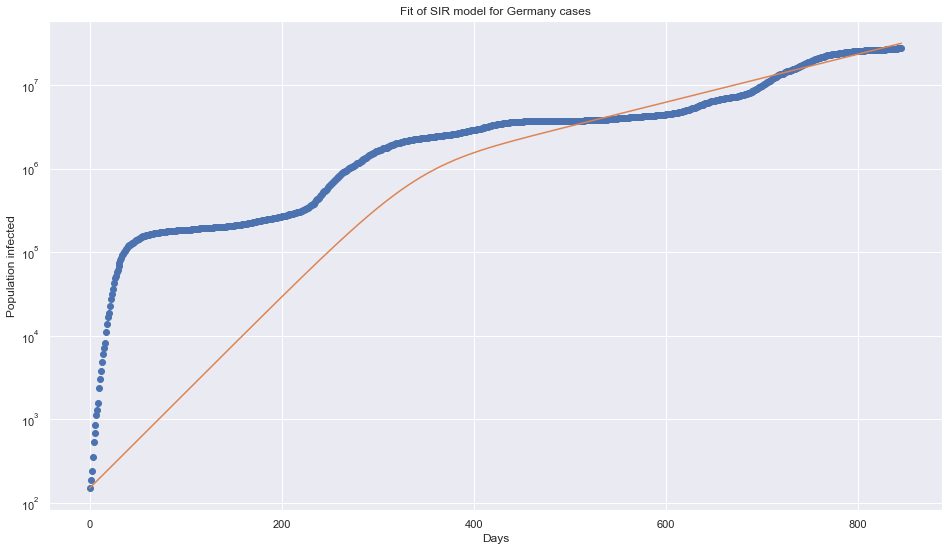

Optimal parameters: beta = 0.019822769151808105  and gamma =  -0.006621589918702324
Basic Reproduction Number R0  -2.993657021226845
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [30]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

## SIR Model for other countries

In [52]:
country = 'Belgium'
total_cases_country = df_analyse.total_cases[df_analyse.location==country]
ydata = np.array(total_cases_country.iloc[35:])
ydata

array([2.670000e+02, 3.140000e+02, 3.140000e+02, 5.590000e+02,
       6.890000e+02, 8.860000e+02, 1.058000e+03, 1.243000e+03,
       1.486000e+03, 1.795000e+03, 2.257000e+03, 2.815000e+03,
       3.401000e+03, 3.743000e+03, 4.269000e+03, 4.937000e+03,
       6.235000e+03, 7.284000e+03, 9.134000e+03, 1.083600e+04,
       1.189900e+04, 1.277500e+04, 1.396400e+04, 1.534800e+04,
       1.677000e+04, 1.843100e+04, 1.969100e+04, 2.081400e+04,
       2.219400e+04, 2.340300e+04, 2.498300e+04, 2.666700e+04,
       2.801800e+04, 2.964700e+04, 3.058900e+04, 3.111900e+04,
       3.357300e+04, 3.480900e+04, 3.613800e+04, 3.718300e+04,
       3.849600e+04, 3.998300e+04, 4.095600e+04, 4.188900e+04,
       4.279700e+04, 4.429300e+04, 4.532500e+04, 4.613400e+04,
       4.668700e+04, 4.733400e+04, 4.785900e+04, 4.851900e+04,
       4.903200e+04, 4.951700e+04, 4.990600e+04, 5.026700e+04,
       5.050900e+04, 5.078100e+04, 5.142000e+04, 5.201100e+04,
       5.259600e+04, 5.308100e+04, 5.344900e+04, 5.3779

In [55]:
t=np.arange(len(ydata))
# ensure re-initialization
N0 = df_analyse.population[df_analyse.location==country].iloc[35]        # new: use population from dataframe to use correct population size
I0=ydata[0]
S0=N0-I0
R0=0
beta
# the resulting curve has to be fitted
# free parameters are here beta and gamma

0.4

C:\Users\Johannes\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.59150879 0.48240563]  start infect: 267.0
Optimal parameters: beta = 0.2882514501421181  and gamma =  0.2693231312981002


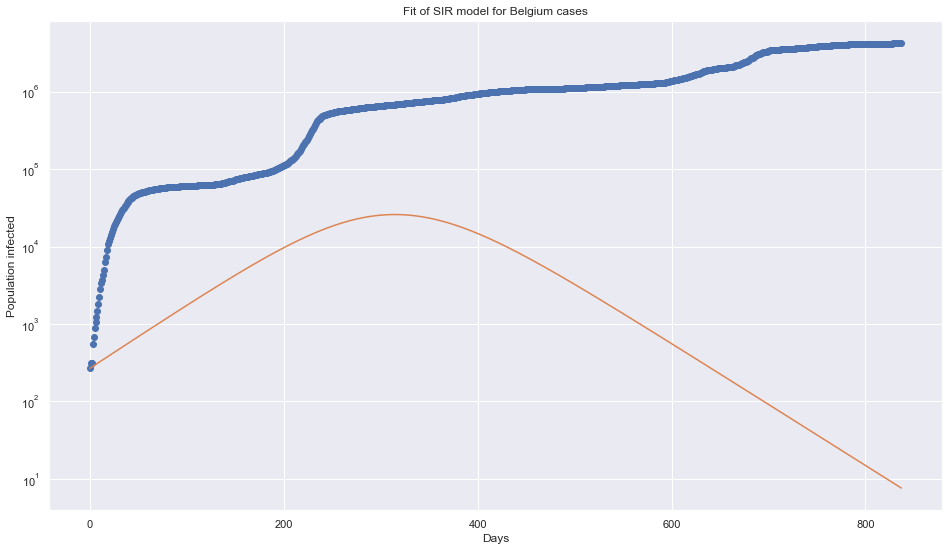

Optimal parameters: beta = 0.2882514501421181  and gamma =  0.2693231312981002
Basic Reproduction Number R0  1.070281073715377
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [56]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
# get the final fitted curve
fitted=fit_odeint(t, *popt)
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title(f"Fit of SIR model for {country} cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")